In [149]:
import rfpimp
from rfpimp import *
import shap
import xgboost as xgb
import numpy as np
import pandas as pd
import statsmodels.api as sm
import category_encoders as ce
import missingno as msno

from category_encoders import CountEncoder
from category_encoders import WOEEncoder
from category_encoders import HashingEncoder


from geopy.geocoders import Nominatim

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA


pd.set_option('display.float_format', lambda x: '%.3f' % x)

Load data and Split

In [175]:
df_raw = pd.read_csv("train.csv")
X_train, X_validation = train_test_split(df_raw, test_size=0.33, random_state=1982)

DROP FEATURES

In [177]:
#coulumns with string values
cols_drop=['property_name','property_summary','property_space', 
'property_desc','property_neighborhood','property_notes','property_transit',
'property_access','property_interaction', 'property_rules', 'host_about','host_response_time']

X_train=X_train.drop(columns=cols_drop)
X_validation=X_validation.drop(columns=cols_drop)

#cols with different tuple lengts
cols_drop_fornow=['host_location','host_id','extra', 'host_verified','property_amenities','property_last_updated','host_nr_listings_total']

X_train=X_train.drop(columns=cols_drop_fornow)
X_validation=X_validation.drop(columns=cols_drop_fornow)


MISSING Values

In [178]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_columns = X_train.select_dtypes(include=numerics).columns 
non_numeric_cols = [col for col in X_train.columns if col not in numeric_columns]

In [181]:
for column in non_numeric_cols:
    X_train[column].fillna(X_train[column].mode()[0], inplace=True)
    X_validation[column].fillna(X_train[column].mode()[0], inplace=True)


In [182]:
for column in numeric_columns:
    X_train[column].fillna(X_train[column].mean(), inplace=True)
    X_validation[column].fillna(X_train[column].mean(), inplace=True)

In [183]:
X_validation.isna().sum()

property_id                 0
property_zipcode            0
property_lat                0
property_lon                0
property_type               0
property_room_type          0
property_max_guests         0
property_bathrooms          0
property_bedrooms           0
property_beds               0
property_bed_type           0
property_sqfeet             0
property_scraped_at         0
host_since                  0
host_response_rate          0
host_nr_listings            0
booking_price_covers        0
booking_min_nights          0
booking_max_nights          0
booking_availability_30     0
booking_availability_60     0
booking_availability_90     0
booking_availability_365    0
booking_cancel_policy       0
reviews_num                 0
reviews_first               0
reviews_last                0
reviews_rating              0
reviews_acc                 0
reviews_cleanliness         0
reviews_checkin             0
reviews_communication       0
reviews_location            0
reviews_va

RECENCY

In [190]:
def recency_calculation(df,recency_variables_list):
    recency_columns=["recency_"+ i for i in recency_variables_list]

    for var, new_var in zip(recency_variables_list, recency_columns):
        df[var] = pd.to_datetime(df[var])
        recency_func = lambda x: (pd.datetime.today() - x).days
        df[new_var] = df[var].apply(recency_func)
    
    #drop the original variables
    df=df.drop(columns=recency_variables_list)
    return(df)

recency_variables=["reviews_last" ,"reviews_first" ,"host_since",  "property_scraped_at"]

X_train= recency_calculation(X_train,recency_variables )
X_validation =  recency_calculation(X_validation,recency_variables )


The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future versio

ENCODING categorical variables: 

In [184]:
#ORDINAL ENCODING
#Find category order
df_raw['booking_cancel_policy'].unique()
#create dictionary to order categories
cancel_dict={'flexible':4,'moderate': 3, 'strict': 2, 'super_strict_30':1}
#create variable with encoded category
X_train['encoded_booing_cancel_policy']=X_train.booking_cancel_policy.map(cancel_dict)
X_validation['encoded_booing_cancel_policy']=X_validation.booking_cancel_policy.map(cancel_dict)

X_train['property_bed_type'].unique()
cancel_dict={'Airbed':1,'Couch': 2, 'Futon': 3, 'Pull-out Sofa':4,'Real Bed':5}
X_train['encoded_property_bed_type']=X_train.property_bed_type.map(cancel_dict)
X_validation['encoded_property_bed_type']=X_validation.property_bed_type.map(cancel_dict)

X_train['property_room_type'].unique()
cancel_dict={'Shared room':1,'Private room': 2, 'Entire home/apt': 3}
X_train['encoded_property_room_type']=X_train.property_room_type.map(cancel_dict)
X_validation['encoded_property_room_type']=X_validation.property_room_type.map(cancel_dict)

#drop original categorical columns that are encoded into new categories
X_train=X_train.drop(columns=['booking_cancel_policy','property_bed_type','property_room_type'])
X_validation=X_validation.drop(columns=['booking_cancel_policy','property_bed_type','property_room_type'])

#make list: should not be standardized
ordinal_encoded_cols=['encoded_property_room_type','encoded_property_bed_type','encoded_booing_cancel_policy']


Count encoding: problems with property_type all values Nan=> maybe this is the mode of the data and use only one class of counts?=> DROP FOR NOW

In [ ]:
# create a list of variables on which this can be used and list with encoded variable names
count_list=['property_zipcode', 'property_type']
count_encode_list=["count_encoded"+ i for i in count_list]
for var, encoded_var in zip(count_list, count_encode_list):
    # Create an instance of the CountEncoder class

    encoder = CountEncoder()
    # Fit the encoder to the column
    encoder.fit(X_train[var])
    # Transform the column using the encoder
    encoded_column = encoder.transform(X_train[var])
    # Add the encoded column to the original DataFrame
    X_train[encoded_var] = encoded_column

    #use fit of X_train for validation set
    encoded_column = encoder.transform(X_validation[var])
    X_validation[encoded_var] = encoded_column

#DELETE ORIGINAL VARIABLES
X_train=X_train.drop(columns=count_list)
X_validation=X_validation.drop(columns=count_list)

In [208]:
#update numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_columns = X_train.select_dtypes(include=numerics).columns
#exclude the ordinal encoded features from the numeric columns: should not be scaled 
numeric_columns = [col for col in numeric_columns if col not in ordinal_encoded_cols]
non_numeric_cols = [col for col in X_train.columns if col not in numeric_columns]



Standardizing

In [212]:
scaler = preprocessing.StandardScaler().fit(X_train[numeric_columns])
X_train_scaled = scaler.transform(X_train[numeric_columns])
X_validation_scaled = scaler.transform(X_validation[numeric_columns])

In [213]:
X_train_scaled_df = pd.DataFrame(X_train_scaled)
X_train_scaled_df.columns = numeric_columns
X_train_scaled_df["property_id"] = list(X_train.index)

X_validation_scaled_df = pd.DataFrame(X_validation_scaled)
X_validation_scaled_df.columns = numeric_columns
X_validation_scaled_df["property_id"] = list(X_validation.index)

In [214]:
#create df with only non-numeric columns
X_train_encoded =X_train[non_numeric_cols]
X_validation_encoded=X_validation[non_numeric_cols]

In [215]:
X_train_encoded_df=pd.DataFrame(X_train_encoded)
X_train_encoded_df["property_id"] = list(X_train.index)

X_validation_encoded_df=pd.DataFrame(X_validation_encoded)
X_validation_encoded_df["property_id"] = list(X_validation.index)


MERGE numerical and categorical columns

In [216]:
X_train_fit = pd.merge(X_train_scaled_df, X_train_encoded.reset_index(), on='property_id')
X_validation_fit = pd.merge(X_validation_scaled_df, X_validation_encoded.reset_index(), on='property_id')

In [217]:
X_train = X_train_fit.loc[:, X_train_fit.columns != 'target'].drop(columns = "property_id")
y_train = X_train_fit.target

X_validation = X_validation_fit.loc[:, X_validation_fit.columns != 'target'].drop(columns = "property_id")
y_validation = X_validation_fit.target

FEATURE ENGINEERING: added after standardization so  may have to put these before the standardization: problems with zero denominators! so cannot use this feature engineering


X_train['guests_beds']=X_train['property_max_guests']/X_train['property_beds']
X_train['guests_bedrooms']=X_train['property_max_guests']/X_train['property_bedrooms']
X_train['guests_bathrooms']=X_train['property_max_guests']/X_train['property_bathrooms']
X_train['guests_sqfeet']=X_train['property_max_guests']/X_train['property_sqfeet']
X_train['beds_bedrooms']=X_train['property_beds']/X_train['property_bedrooms']
X_train['beds_bathrooms']=X_train['property_beds']/X_train['property_bathrooms']
X_train['beds_sqfeet']=X_train['property_beds']/X_train['property_sqfeet']

X_validation['guests_beds']=X_validation['property_max_guests']/X_validation['property_beds']
X_validation['guests_bedrooms']=X_validation['property_max_guests']/X_validation['property_bedrooms']
X_validation['guests_bathrooms']=X_validation['property_max_guests']/X_validation['property_bathrooms']
X_validation['guests_sqfeet']=X_validation['property_max_guests']/X_validation['property_sqfeet']
X_validation['beds_bedrooms']=X_validation['property_beds']/X_validation['property_bedrooms']
X_validation['beds_bathrooms']=X_validation['property_beds']/X_validation['property_bathrooms']
X_validation['beds_sqfeet']=X_validation['property_beds']/X_validation['property_sqfeet']

PCA

In [228]:
availability_cols = ['booking_availability_30', 
           'booking_availability_60', 
           'booking_availability_90', 
           'booking_availability_365']
pca = PCA(n_components=1)
pca.fit(X_train[availability_cols])
X_train['availability'] = pca.transform(X_train[availability_cols])
X_validation['availability'] = pca.transform(X_validation[availability_cols])
fff = pca.fit(X_train[availability_cols])

X_train.drop(availability_cols, axis=1, inplace=True)
X_validation.drop(availability_cols, axis=1, inplace=True)


review_cols = ['reviews_rating',
                    'reviews_acc',
                    'reviews_cleanliness', 
                    'reviews_checkin',
                    'reviews_communication',
                    'reviews_location', 
                    'reviews_value']
pca = PCA(n_components=1)
pca.fit(X_train[review_cols])
X_train['reviews'] = pca.transform(X_train[review_cols])
X_validation['reviews'] = pca.transform(X_validation[review_cols])
fff = pca.fit(X_train[review_cols])

X_train.drop(review_cols, axis=1, inplace=True)
X_validation.drop(review_cols, axis=1, inplace=True)



review_cols2 = ['reviews_num',
                    'reviews_per_month']
pca = PCA(n_components=1)
pca.fit(X_train[review_cols2])
X_train['reviews_num_pca'] = pca.transform(X_train[review_cols2])
X_validation['reviews_num_pca'] = pca.transform(X_validation[review_cols2])

X_train.drop(review_cols2, axis=1, inplace=True)
X_validation.drop(review_cols2, axis=1, inplace=True)

Model XGBoost

In [ ]:
regressor=xgb.XGBRegressor(eval_metric='rmse')

# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)


In [170]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}


In [229]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [172]:
predictions = regressor.predict(X_validation)
from sklearn.metrics import mean_squared_error
RMSE= np.sqrt( mean_squared_error(y_validation, predictions) )
print("The score is %.5f" % RMSE )

The score is 1.02822


Variable importance: see https://explained.ai/rf-importance/index.html#neutral

 Spearman's rank-order correlation

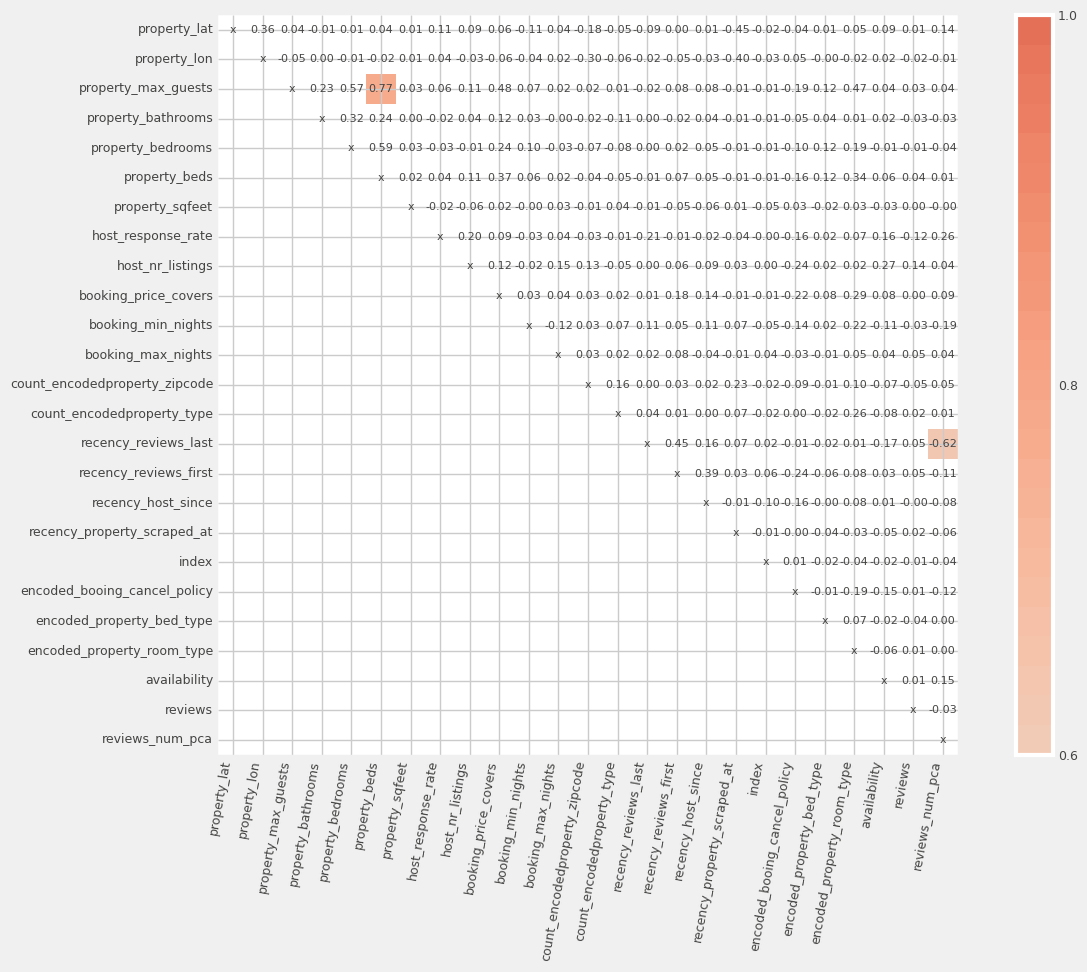

In [230]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(X_train, figsize=(15,10))
viz.view()

Combine correlating variables together 

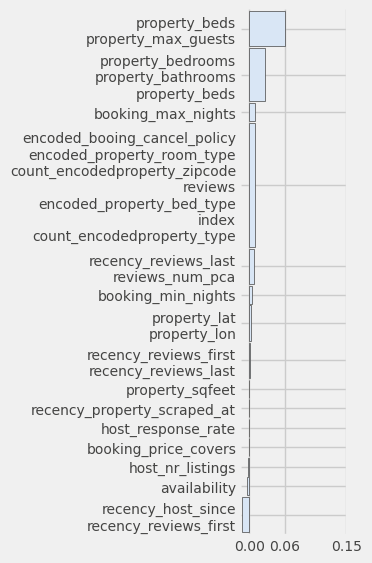

In [233]:
features=[['property_lat','property_lon'],['property_beds','property_max_guests'],['property_bedrooms','property_bathrooms','property_beds'],
          'property_sqfeet', 'host_response_rate','host_nr_listings','booking_price_covers','booking_min_nights','booking_max_nights',
          ['recency_host_since','recency_reviews_first'],['recency_reviews_first','recency_reviews_last'],
            'availability','recency_property_scraped_at',['recency_reviews_last','reviews_num_pca']]
imp = importances(regressor, X_validation, y_validation, features=features) # permutation
viz = plot_importances(imp)
viz.view()